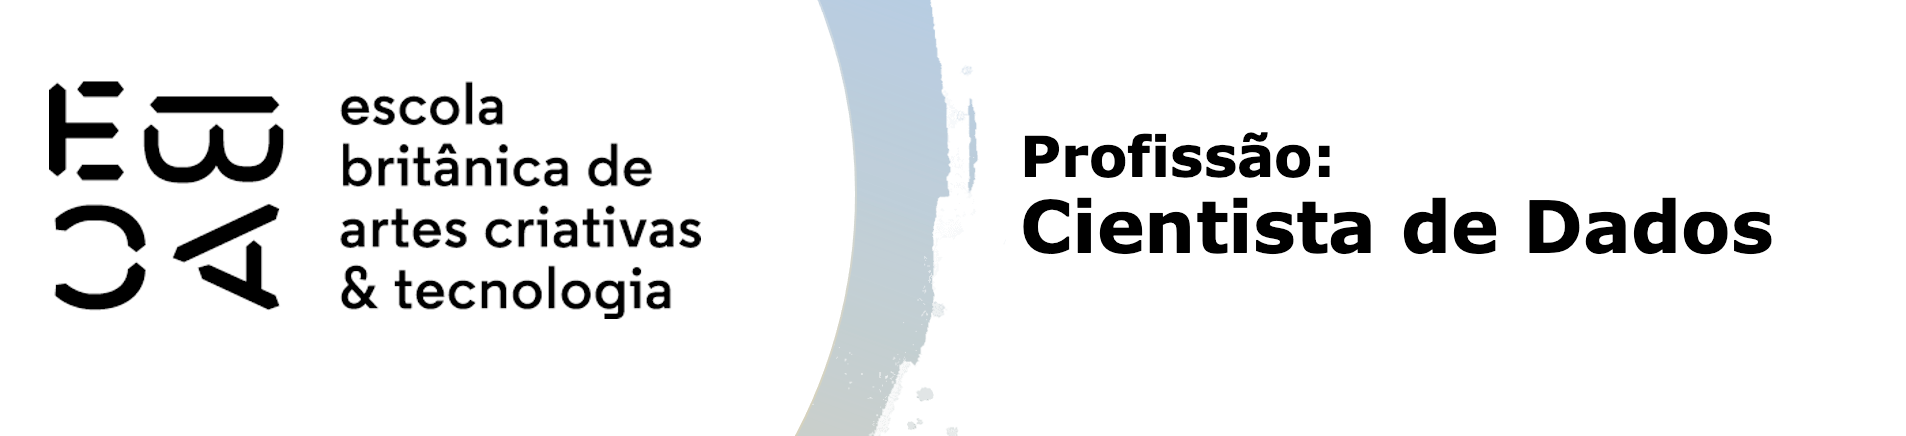

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from tqdm.notebook import tqdm

In [3]:
df = pd.read_csv('online_shoppers_intention.csv')

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [4]:
def plot_distribuicao(data:pd.DataFrame,colunas_plot:int=3):
    """
    Função para plotar histogramas de todas as colunas de um DataFrame.
    
    Parâmetros:
    data (DataFrame): DataFrame contendo os dados a serem plotados.
    colunas_plot (int): Número de colunas do gráfico
    
    Retorna: None
    """

    num_linhas = int(np.ceil(len(data.columns) / colunas_plot))

    fig, axes = plt.subplots(num_linhas, colunas_plot, figsize=(15, num_linhas * 5))

    for i, coluna in enumerate(data.columns):
        row = i // colunas_plot
        col = i % colunas_plot
        sns.histplot(df[coluna], kde=True, ax=axes[row, col])
        axes[row, col].set_title(coluna)

    # Remove subplots vazios
    for j in range(i + 1, num_linhas * colunas_plot):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()


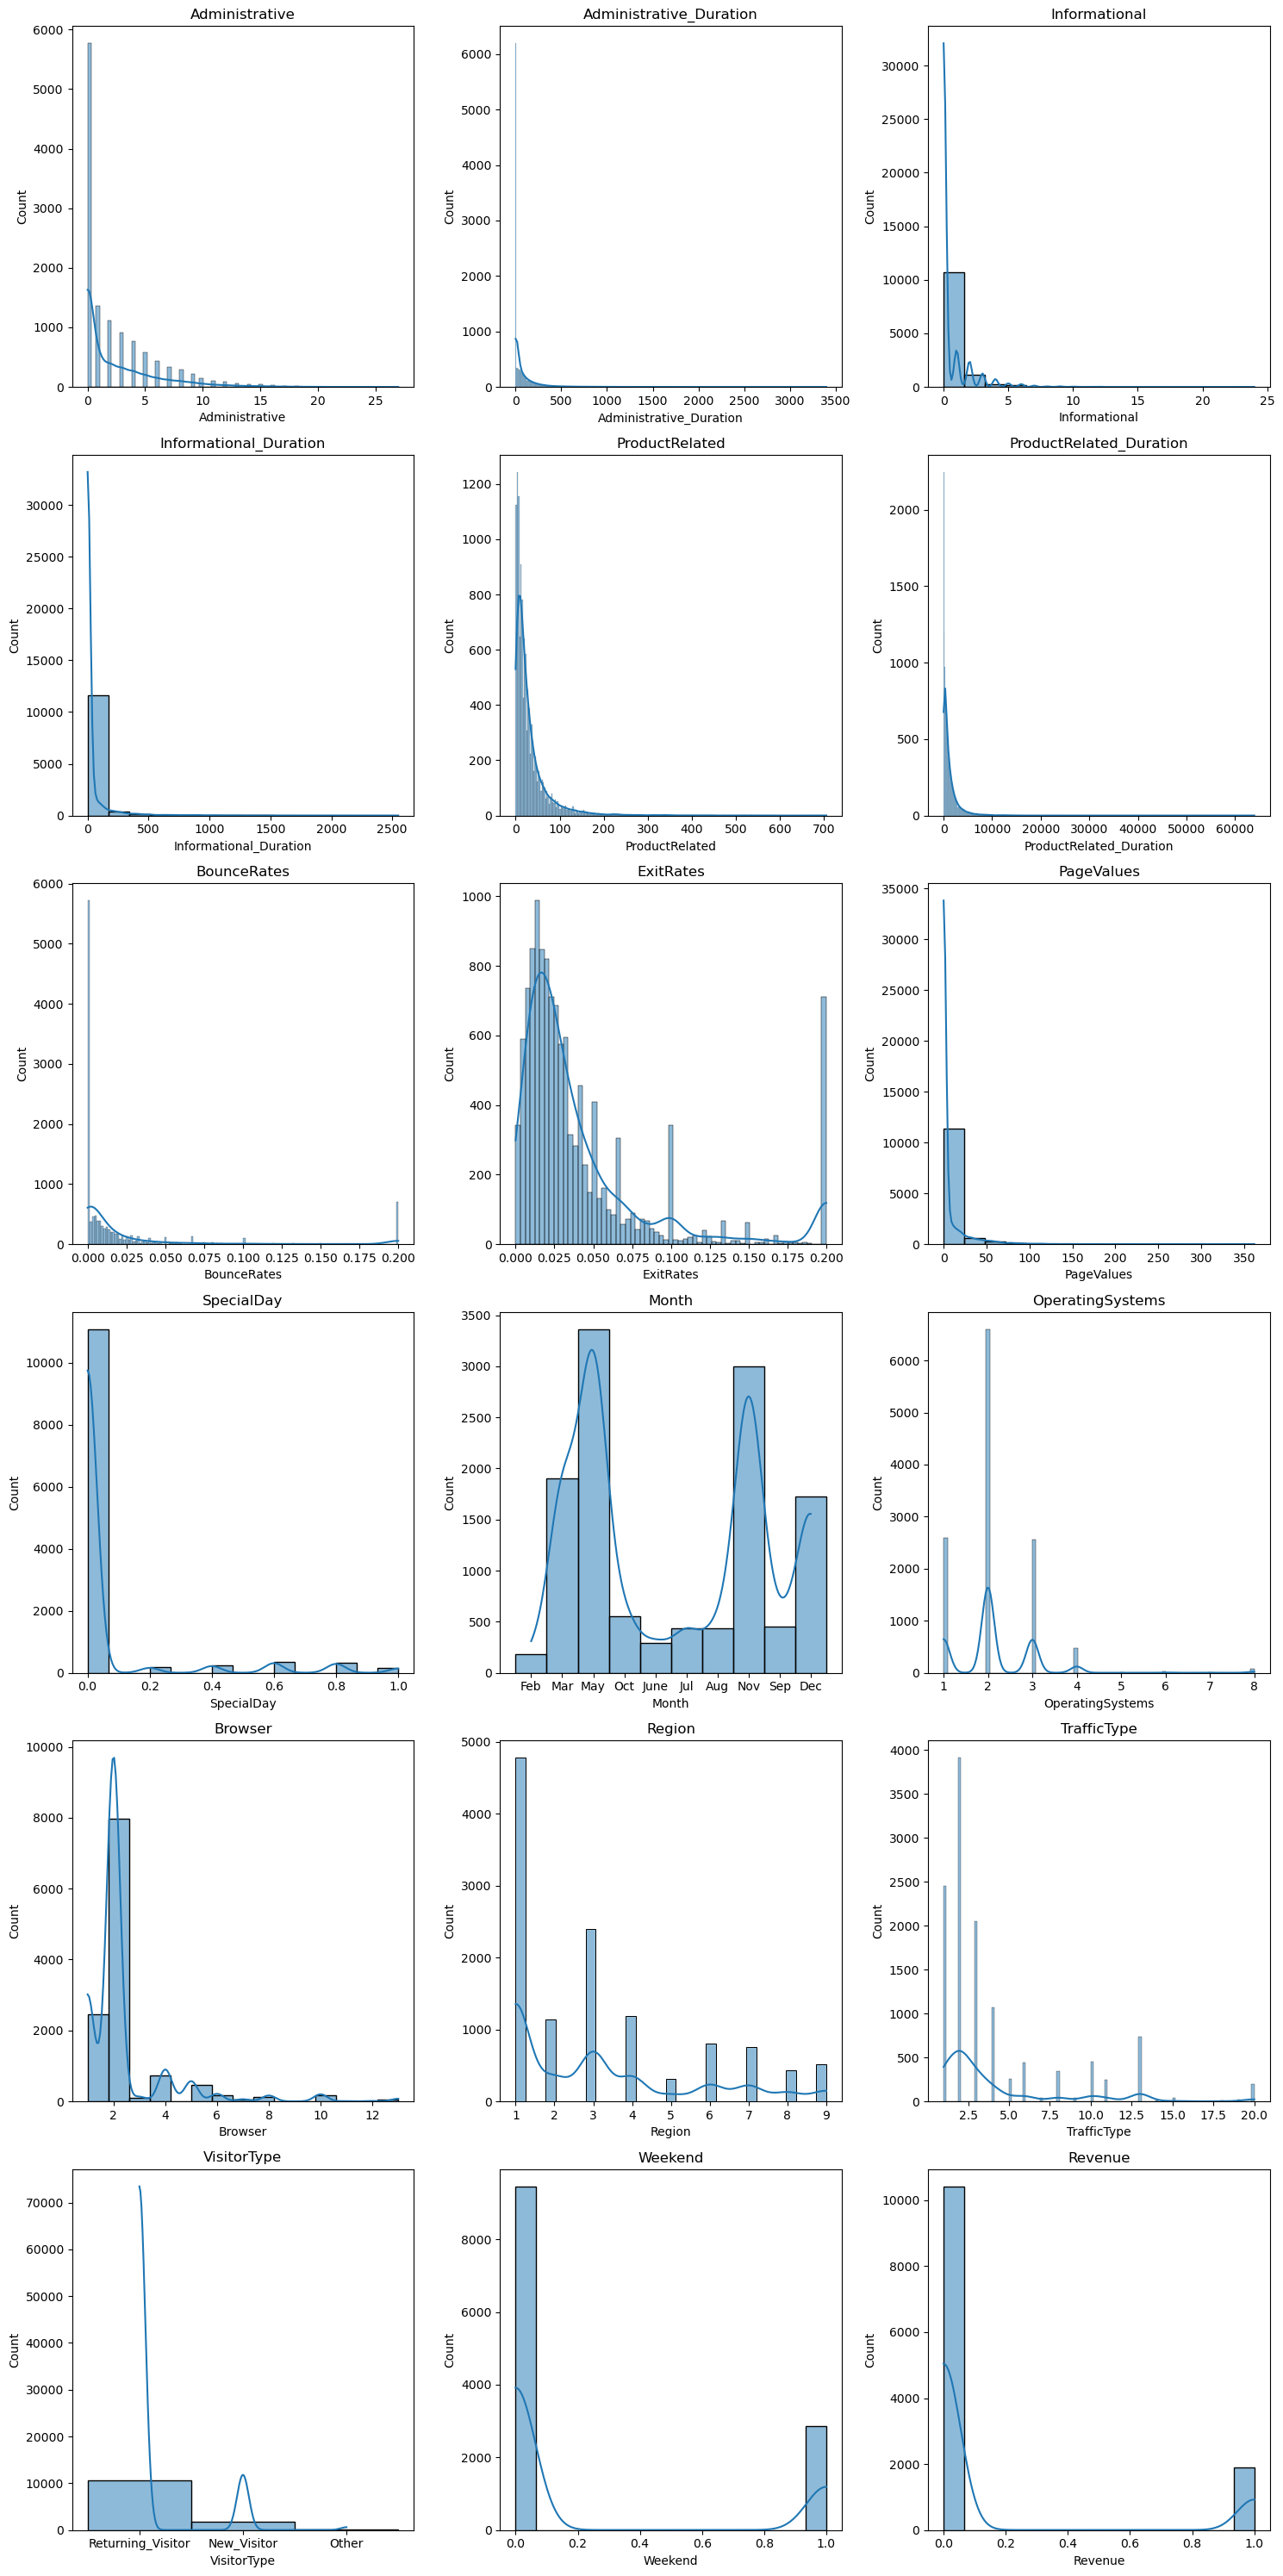

In [5]:
plot_distribuicao(df)

In [6]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [9]:
# Selecionando apenas as primeiras seis variáveis
df_variaveis = df.iloc[:,0:6]
df_variaveis.describe()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230


In [10]:
df_variaveis_pad = pd.DataFrame(StandardScaler().fit_transform(df_variaveis), columns = df_variaveis.columns)
df_variaveis_pad.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
count,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04,1.233000e+04
mean,-2.996612e-17,6.281359e-17,-4.610172e-18,-2.535595e-17,4.610172e-17,-8.298309e-17
std,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00
min,-6.969930e-01,-4.571914e-01,-3.964779e-01,-2.449305e-01,-7.134884e-01,-6.243475e-01
25%,-6.969930e-01,-4.571914e-01,-3.964779e-01,-2.449305e-01,-5.560920e-01,-5.281214e-01
50%,-3.959377e-01,-4.147639e-01,-3.964779e-01,-2.449305e-01,-3.087548e-01,-3.113566e-01
75%,5.072280e-01,7.035981e-02,-3.964779e-01,-2.449305e-01,1.409492e-01,1.407881e-01
max,7.431499e+00,1.876956e+01,1.849960e+01,1.786868e+01,1.513858e+01,3.280678e+01


## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

In [11]:
SQD = []
K = range(1, 15)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(df_variaveis_pad)
    SQD.append(km.inertia_)

  0%|          | 0/14 [00:00<?, ?it/s]

In [13]:
SQD

[73980.0,
 51210.526273941345,
 43201.822260285684,
 37325.99685542246,
 33470.916474777645,
 29691.125613995606,
 26739.770939113856,
 24157.16102005164,
 22486.589980582066,
 21049.066802534253,
 19703.246588971677,
 18862.116201646295,
 18137.131315440365,
 17303.24101209276]

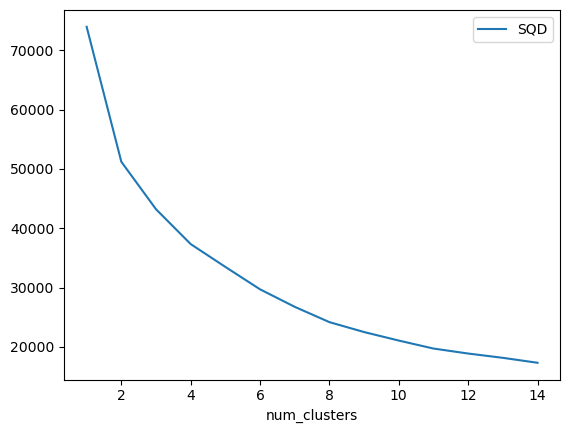

In [14]:
pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD}).plot(x = 'num_clusters', y = 'SQD');

In [15]:
variaveis = df_variaveis_pad.columns.to_list() 

In [16]:

# Inicializar uma lista vazia que vai conter os valores da silueta média
siluetas = []
# Este é o número máximo de grupos que vamos testar
max_clusters = 10

# O loop percorre de 2 até o máximo de clusters
for n_clusters in tqdm(range(2, max_clusters+1)):
    # Aqui rodamos o k-means
    km = KMeans(n_clusters=n_clusters,n_init=10).fit(df_variaveis_pad[variaveis])
    # Aqui calculamos a silueta e guardamos o resultado na lista 'siluetas'
    siluetas.append(silhouette_score(df_variaveis_pad[variaveis], km.labels_))
    # Essa list comprehendion define o nome dos grupos
    nomes_grupos = ['grupo_' + str(g) for g in range(n_clusters)]
    # Agora vamos adicionar uma coluna no dataframe df_variaveis_pad com o agrupamento construido
    df_variaveis_pad['grupos_'+str(n_clusters)] = pd.Categorical.from_codes(km.labels_, categories = nomes_grupos)


  0%|          | 0/9 [00:00<?, ?it/s]

<Axes: xlabel='n_clusters'>

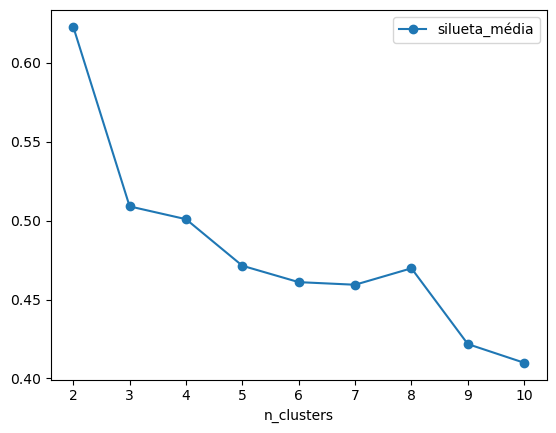

In [17]:
df_silueta = pd.DataFrame({'n_clusters': list(range(2, max_clusters+1)), 'silueta_média': siluetas})
df_silueta.plot.line(x = 'n_clusters', y = 'silueta_média', marker='o')

**AVALIAÇÃO**
- Na análise do `Método do Cotovelo` a quantidade de grupo mais adequada visualmente é igual a 2.
- Na análise do `Coeficiente de Silueta` a quantidade de grupo mais adequada visualmente é igual a 2.

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

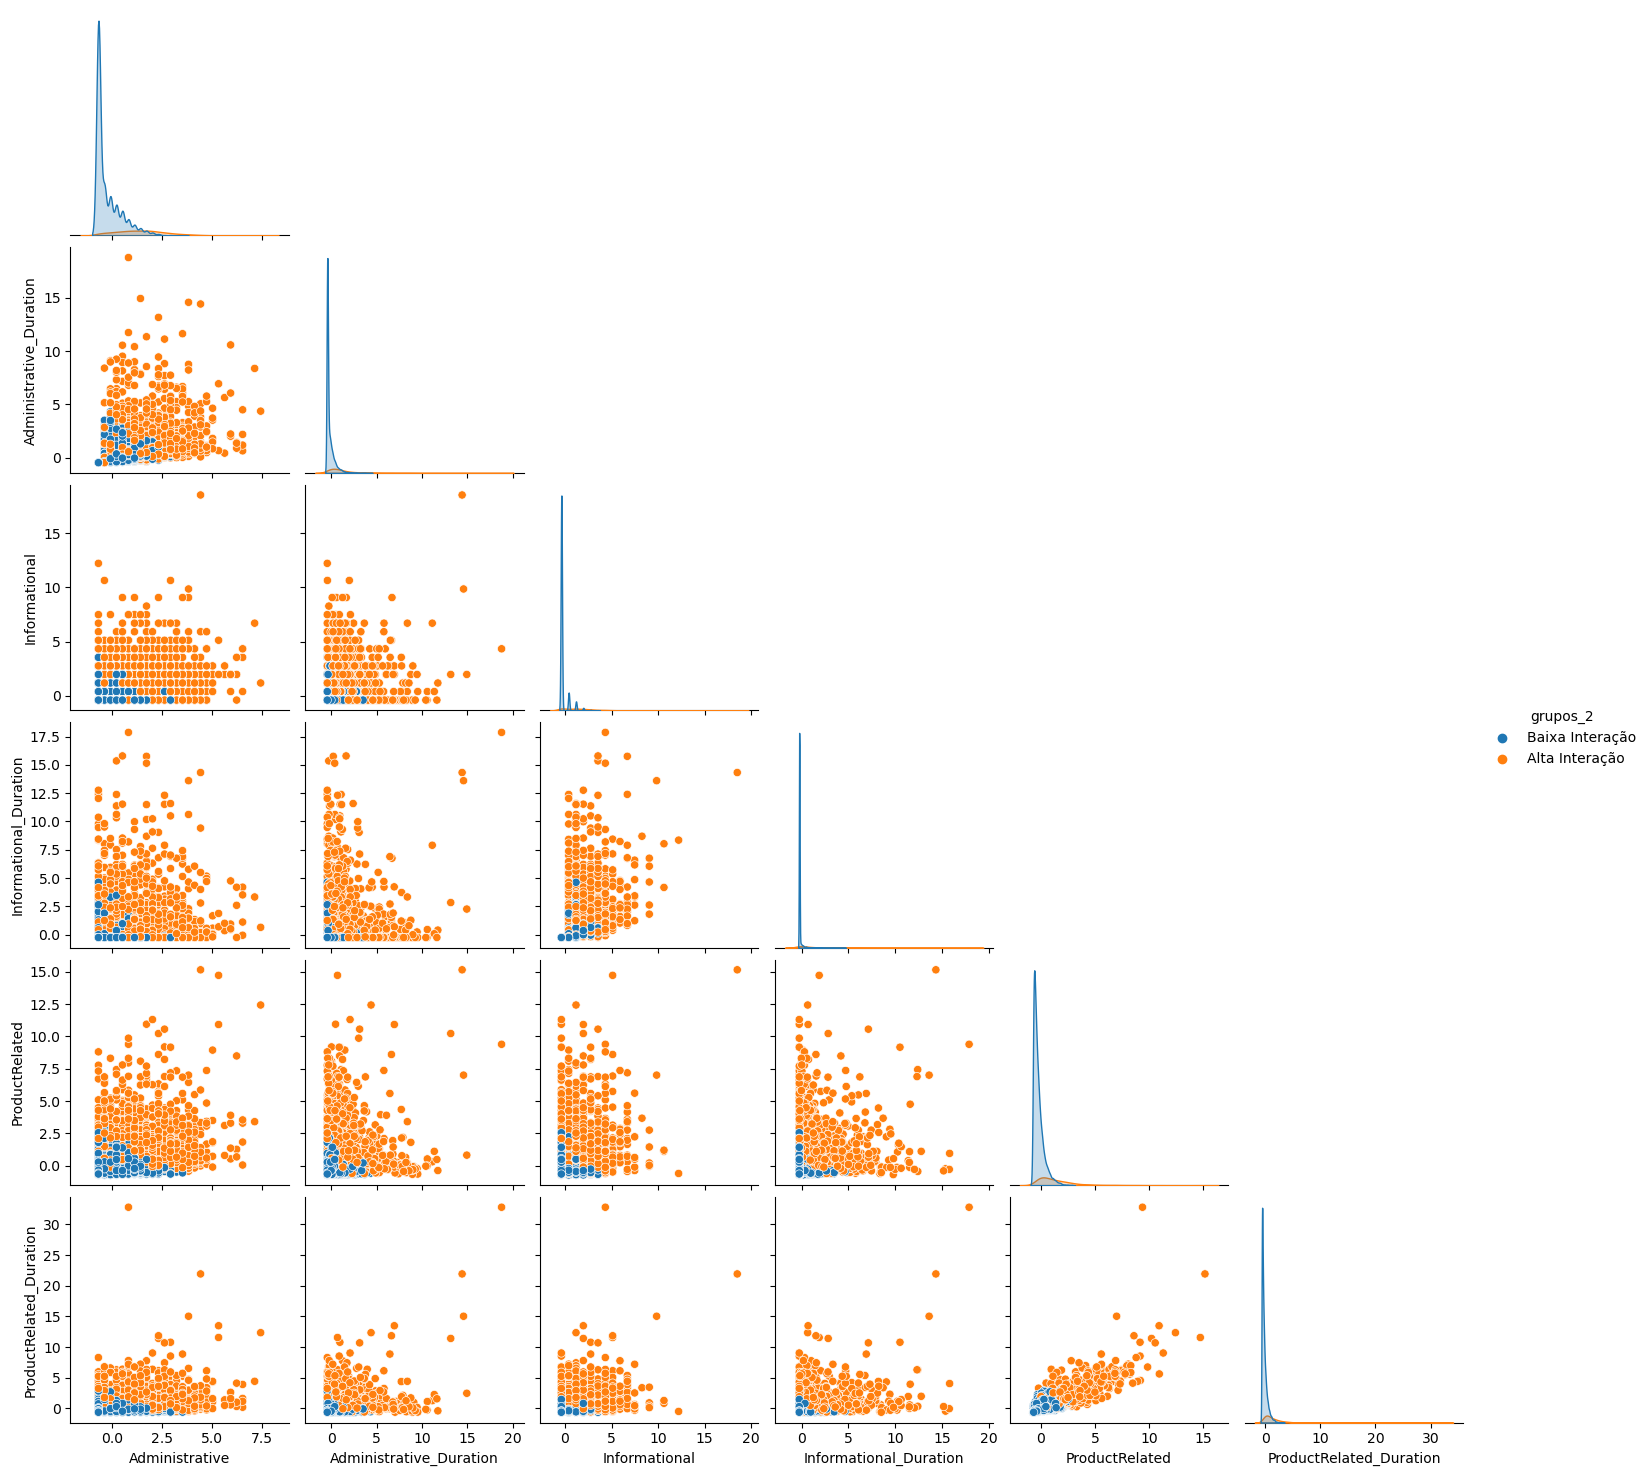

In [45]:
#Avaliação com 2 grupos, dividindo os grupos em baixa e alta interação
df_grupo2 = df_variaveis_pad[variaveis + ['grupos_2']]
df_grupo2['grupos_2'] = df_grupo2['grupos_2'].replace({'grupo_0':'Baixa Interação', 'grupo_1':'Alta Interação'})
sns.pairplot(df_grupo2,hue='grupos_2', corner=True)


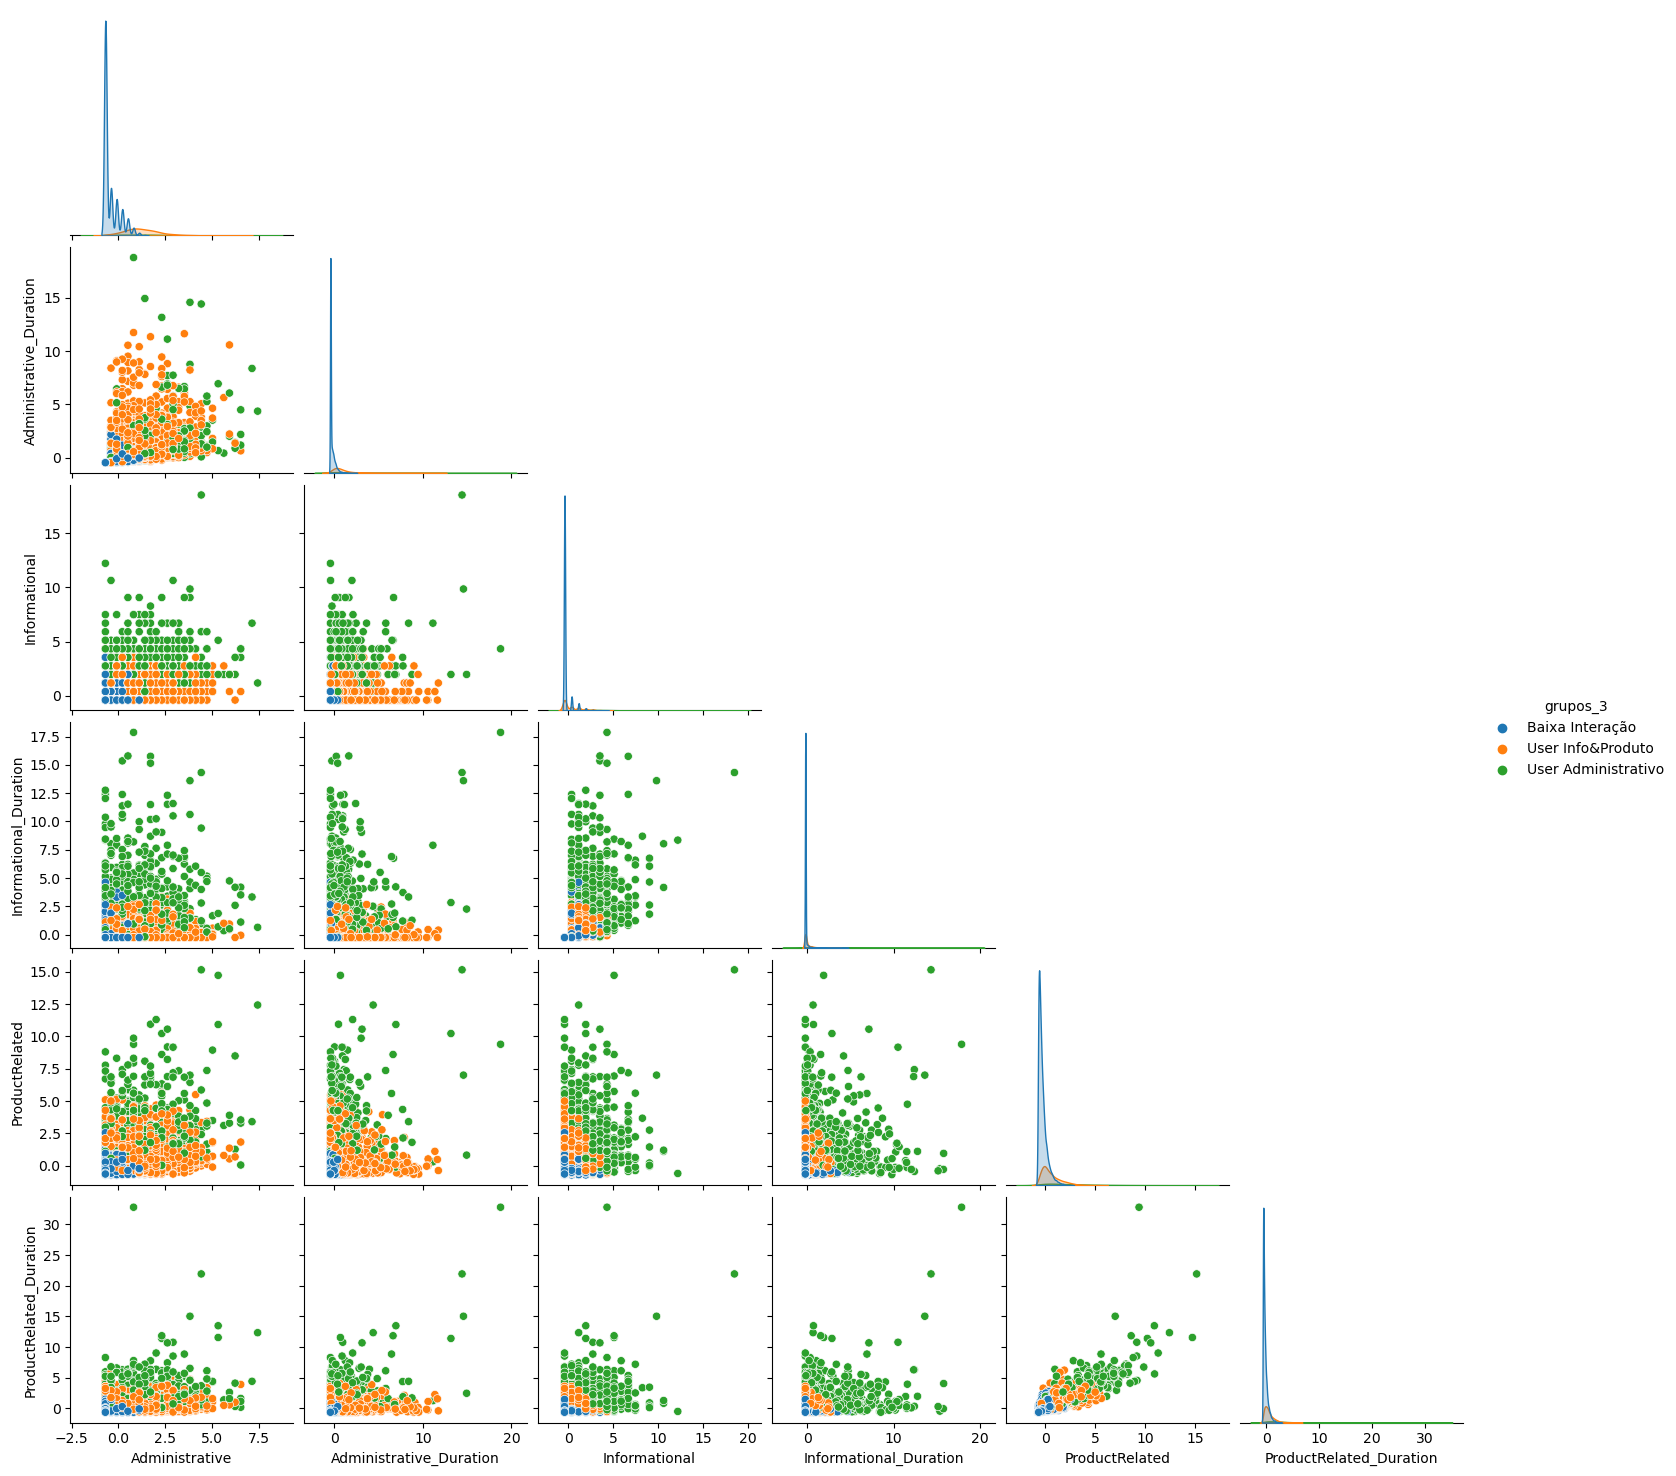

In [46]:
#Avaliação com 3 grupos, dividindo os grupos em: Grupo 0: Baixo Interação, Grupo 1: User Info&Produto e Grupo 2: User Administrativo
df_grupo3 = df_variaveis_pad[variaveis + ['grupos_3']]
df_grupo3['grupos_3'] = df_grupo3['grupos_3'].replace({'grupo_0':'Baixa Interação', 'grupo_1':'User Info&Produto','grupo_2':'User Administrativo'})
sns.pairplot(df_grupo3,hue='grupos_3', corner=True)

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [59]:
#avaliando com 2 grupos
df_grupo2[['BounceRates','Revenue']] = df[['BounceRates', 'Revenue']]
grupo_Revenue = df_grupo2.groupby('grupos_2')['Revenue'].mean().sort_values(ascending=False).index[0]
grupo_BounceRates = df_grupo2.groupby('grupos_2')['BounceRates'].mean().sort_values(ascending=False).index[0]

print(f'Dos clientes agrupados em 2 grupos, os que possuem maior conversão de compra são do grupo: {grupo_Revenue}\n')
print(f'Dos clientes agrupados em 2 grupos, os que possuem maior BounceRates são do grupo: {grupo_BounceRates}')

Dos clientes agrupados em 2 grupos, os que possuem maior conversão de compra são do grupo: Alta Interação

Dos clientes agrupados em 2 grupos, os que possuem maior BounceRates são do grupo: Baixa Interação


In [61]:
#avaliando com 3 grupos
df_grupo3[['BounceRates','Revenue']] = df[['BounceRates', 'Revenue']]
grupo_Revenue = df_grupo3.groupby('grupos_3')['Revenue'].mean().sort_values(ascending=False).index[0]
grupo_BounceRates = df_grupo3.groupby('grupos_3')['BounceRates'].mean().sort_values(ascending=False).index[0]

print(f'Dos clientes agrupados em 3 grupos, os que possuem maior conversão de compra são do grupo: {grupo_Revenue}\n')
print(f'Dos clientes agrupados em 3 grupos, os que possuem maior BounceRates são do grupo: {grupo_BounceRates}')

Dos clientes agrupados em 3 grupos, os que possuem maior conversão de compra são do grupo: User Administrativo

Dos clientes agrupados em 3 grupos, os que possuem maior BounceRates são do grupo: Baixa Interação
